In [2]:
pip install torch

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/203.1 MB 5.6 MB/s eta 0:00:37
   ---------------------------------------- 0.8/203.1 MB 10.2 MB/s eta 0:00:20
   ---------------------------------------- 1.7/203.1 MB 15.5 MB/s eta 0:00:13
    --------------------------------------- 2.7/203.1 MB 17.5 MB/s eta 0:00:12
    --------------------------------------- 3.7/203.1 MB 18.2 MB/s eta 0:00:11
    --------------------------------------- 5.0/203.1 MB 20.1 MB/s eta 0:00:10
   - -------------------------------------- 5.7/203.1 MB 19.1 MB/s eta 0:00:11
   - -------------------------------------- 6.7/203.1 MB 19.3 MB/s eta 0:00:11
   - -------------------------------------- 8.1/203.1 MB 20.7 MB/s eta 0:00:10
   - -------------------------------------- 9.3/203.1 MB 21.2 MB/s eta 0:00:10
   -- ------------------------------------- 10.8/203.1 MB 25.2 MB/s eta 0:00:08
   -- ------------------------------------- 12.5/203.1 MB 28

In [4]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


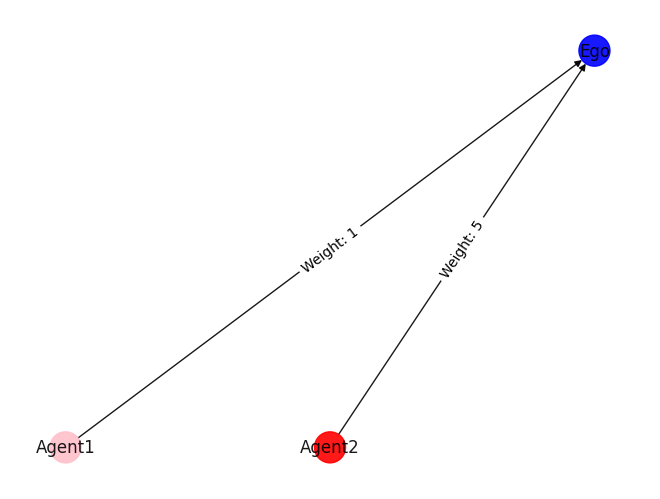

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.bipartite.basic import color


# Node Superclass
class Node:
    def __init__(self, name, x_global_position, y_global_position, x_velocity, y_velocity,
                 x_acceleration, y_acceleration):
        self.name = name
        self.x_global_position = x_global_position
        self.y_global_position = y_global_position
        self.x_velocity = x_velocity
        self.y_velocity = y_velocity
        self.x_acceleration = x_acceleration
        self.y_acceleration = y_acceleration


# Ego Node Subclass
class EgoNode(Node):
    def __init__(self, name, x_global_position, y_global_position, x_velocity, y_velocity,
                 x_acceleration, y_acceleration, x_angular_rate, y_angular_rate):
        super().__init__(name, x_global_position, y_global_position, x_velocity, y_velocity,
                 x_acceleration, y_acceleration)
        self.x_angular_rate = x_angular_rate
        self.y_angular_rate = y_angular_rate
        self.node_type = 'Ego'


# Agent Node Subclass
class AgentNode(Node):
    def __init__(self, name, x_global_position, y_global_position, x_velocity, y_velocity,
                 x_acceleration, y_acceleration, yaw, category):
        super().__init__(name, x_global_position, y_global_position, x_velocity, y_velocity,
                 x_acceleration, y_acceleration)
        self.yaw = yaw
        self.category = category
        self.node_type = 'Agent'


# Dictionary for agent weights based on their category - Weights are static
agentCategoryToWeightDictionary = {
    'pedestrian' : 1,
    'vehicle' : 5
}

# Dictionary for agent colors - For color_map only
agentColorDictionary = {
    'pedestrian' : 'blue',
    'vehicle' : 'red'
}

# List to hold nodes for all following operations
nodeList = []
# Contains colors for each node
color_map = []


# TODO - These nodes will want to be from the dataset with all their appropriate values
Ego = EgoNode('Ego', 10, 10, 0, 0, 0, 0, 0, 0)
Agent1 = AgentNode('Agent1', 2, 4, 0, 0, 0, 0, 0, 'pedestrian')
Agent2 = AgentNode('Agent2', 6, 4, 0, 0, 0, 0, 0, 'vehicle')
# TODO - Don't forget to append the above nodes to the node list
nodeList.append(Ego)
nodeList.append(Agent1)
nodeList.append(Agent2)


# Initializes directed graph
directed_graph = nx.DiGraph()
# Initializes position layout
pos = nx.spring_layout(directed_graph)

# Adds node positions and edges
# TODO - Colors aren't being set to the correct nodes
for node in nodeList:
    pos[node.name] = np.array([node.x_global_position, node.y_global_position])
    # Only adds edges for agent nodes, as all edges point to the ego node
    if node.node_type == 'Agent':
        directed_graph.add_edge(node.name, 'Ego', weight=agentCategoryToWeightDictionary[node.category])
        color_map.append(agentColorDictionary[node.category])
    else:
        color_map.append('pink')


# Draws the directed graph
plt.figure()
nx.draw(
    directed_graph, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in directed_graph.nodes()}
)
# Edge labels
for node in nodeList:
    pos[node.name] = np.array([node.x_global_position, node.y_global_position])
    if node.name != 'Ego':
        nx.draw_networkx_edge_labels(
            directed_graph, pos,
            edge_labels={(node.name, 'Ego'): 'Weight: ' + str(agentCategoryToWeightDictionary[node.category])}
        )
plt.axis('off')
plt.show()

In [ ]:
import torch

# List of nodes in order
node_names = list(directed_graph.nodes())

# Extracting node atriutes
node_features = torch.tensor(
    [
        [
            directed_graph.nodes[node]['pos'][0],  # x position
            directed_graph.nodes[node]['pos'][1],  # y position
            directed_graph.nodes[node]['x_velocity'],
            directed_graph.nodes[node]['y_velocity'],
            directed_graph.nodes[node]['x_acceleration'],
            directed_graph.nodes[node]['y_acceleration'],
    
        ]
        for node in node_names
    ],
    dtype=torch.float32
)

# Extracting edge indixes
edge_index = torch.tensor(
    [
        [node_names.index(u), node_names.index(v)]
        for u, v in directed_graph.edges()
    ],
    dtype=torch.long
).t()

# Extracting edge weights
edge_weights = torch.tensor(
    [
        directed_graph[u][v]['weigt']
        for u, v in directed_graph.edges()
    ],
    dtype=torch.float32
)

print("Node Fetures:", node_features)
print("Edge Index:", edge_index)
print("Edge weighs:", edge_weights)


Node Features: tensor([[ 2.,  4.,  0.,  0.,  0.,  0.],
        [10., 10.,  0.,  0.,  0.,  0.],
        [ 6.,  4.,  0.,  0.,  0.,  0.]])
Edge Index: tensor([[0, 2],
        [1, 1]])
Edge Weights: tensor([1., 5.])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InfluenceEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(InfluenceEncoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc_aggregate = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, node_features, edge_index, edge_weights):
        embeddings = self.fc(node_features)
        embeddings = self.relu(embeddings)
        
        aggregated_embeddings = torch.zeros_like(embeddings)
        
        for i, (src, dest) in enumerate(edge_index.t()):
            aggregated_embeddings[dest] += edge_weights[i] * embeddings[src]
        
   
        ego_index = node_names.index('Ego')  
        influence_vector = self.fc_aggregate(self.relu(aggregated_embeddings[ego_index]))
        
        return influence_vector


In [20]:
# Adds nodes with attributes to the graph and edges
for node in nodeList:
    # Add node to the graph with attributes
    directed_graph.add_node(node.name,
                            pos=np.array([node.x_global_position, node.y_global_position]),
                            x_velocity=node.x_velocity,
                            y_velocity=node.y_velocity,
                            x_acceleration=node.x_acceleration,
                            y_acceleration=node.y_acceleration,
                            node_type=node.node_type)
    
    # Only adds edges for agent nodes, as all edges point to the ego node
    if node.node_type == 'Agennt':
        directed_graph.add_edge(node.name, 'Ego', weight=agentCategoryToWeightDictionary[node.category])
        color_map.append(agentColorDictionary[node.category])
    else:
        color_map.append('pink')


In [ ]:
# Instantiate the GNN
input_dim = node_features.size(1)
hidden_dim = 8 
gnn = InfluenceEncoder(input_dim=input_dim, hidden_dim=hidden_dim)

# Pass the features to the GNN
influence_vector = gnn(node_features, edge_index, edge_weights)

print("Influence Vector:", influence_vector)


Influence Vector: tensor([ 2.9995,  1.3093,  5.0488,  2.6228,  1.1742, -1.9458, -2.8867, -3.8333],
       grad_fn=<ViewBackward0>)


In [16]:
print("Node Features Shape:", node_features.shape)
print("Node Features:", node_features)


Node Features Shape: torch.Size([3, 6])
Node Features: tensor([[ 2.,  4.,  0.,  0.,  0.,  0.],
        [10., 10.,  0.,  0.,  0.,  0.],
        [ 6.,  4.,  0.,  0.,  0.,  0.]])
